# Лабораторная работа № 3
## Виузализация обалсти внимания модели VGGNet (Saliency and grad-CAM)
### Работу выполнил: Сучков Василий Вячеславович (ББМО-01-22)

# ! keras-vis, указанный к использованию в ЛР3 не работает с tensorflow второй версии. Данный проект не будет нормально работать (без глубокого редактирования кода). Был найден обновленный keras-vis. **tf-keras-vis**

## Лабораторная работа будет выполнена с tf-keras-vis

In [2]:
!pip install tf-keras-vis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.1/52.1 kB 1.4 MB/s eta 0:00:00


### **Использование Siliency для определения ключевых областей изображения**

Для начала, необходимо загрузить предобученную модель VGG16 в новой версии keras-vis уже не нужно использовать преобразование функции активации на прямую, это делается позже...


In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model
model = Model(weights='imagenet', include_top=True)

553467096/553467096 [==============================] - 7s 0us/step


Необходимо выбрать 4 изображения из ImageNet одного класса и загрузить в ноутбук, после чего, выполнить задание:

* Загрузить 4 различных изображения из датасета ImageNet и
отобразить их на одном графике



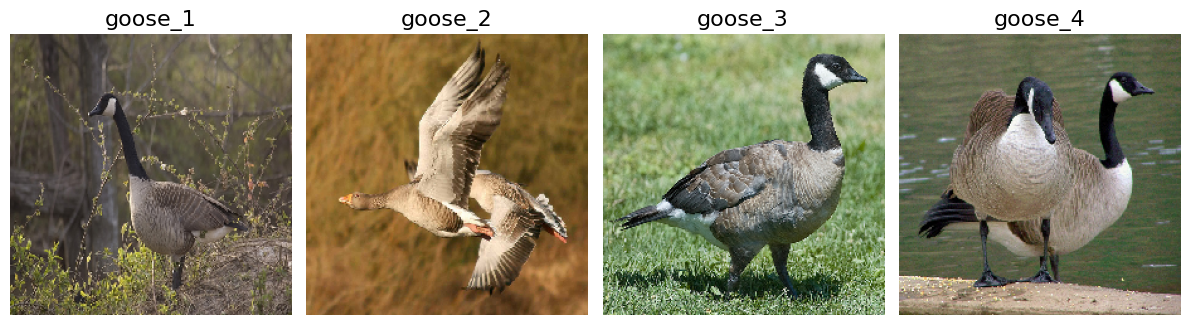

In [10]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from matplotlib import pyplot as plt
# Image titles
image_titles = ['goose_1', 'goose_2', 'goose_3', 'goose_4']

# Load images and Convert them to a Numpy array
img1 = load_img('goose_1.jpg', target_size=(224, 224))
img2 = load_img('goose_2.jpg', target_size=(224, 224))
img3 = load_img('goose_3.jpg', target_size=(224, 224))
img4 = load_img('goose_4.jpg', target_size=(224, 224))
images = np.asarray([np.array(img1), np.array(img2), np.array(img3), np.array(img4)])

# Preparing input data for VGG16
X = preprocess_input(images)

# Rendering
f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].axis('off')
plt.tight_layout()
plt.show()

* Отобразить карты значимости признаков, найти и задать верный
параметр filter_indices

Я выбрал 4 изображения гуся (goose), важно отметить, что нам уже не нужен непосредственно index ImageNet класса для визуализации, нам нужен категориальный выход модели для класса goose, классов всего 1000 следовательно целевой score - массив где все элементы кроме goose будут равны 0.

*В нашем случае класс goose соответствует индексу 99*.

Заменим функцию активации на линейную

In [16]:
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear, GuidedBackpropagation
import tensorflow as tf

replace2linear = ReplaceToLinear()
guided =  GuidedBackpropagation()

def model_modifier_function(cloned_model):
    cloned_model.layers[-1].activation = tf.keras.activations.linear

Устанавливаем классы изображений (все 99)

In [13]:
from tf_keras_vis.utils.scores import CategoricalScore

score = CategoricalScore([99, 99, 99, 99])

Отображаем стандартные ключевые области

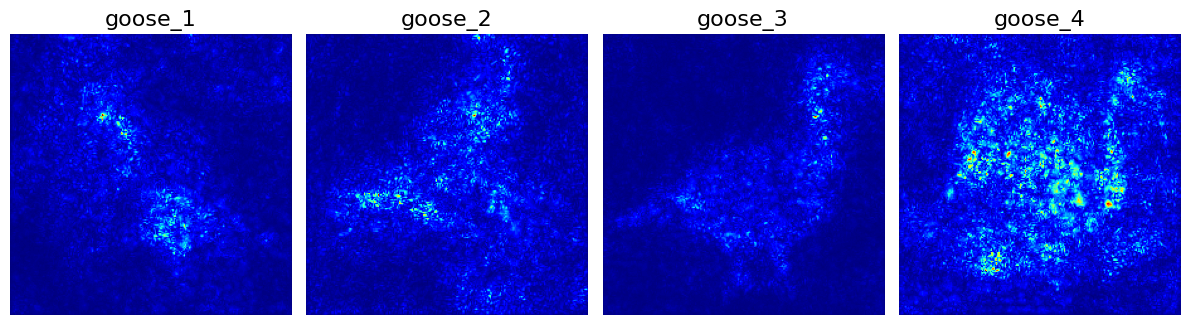

In [42]:
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model,
                    model_modifier=replace2linear,
                    clone=True)

saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

Теперь нам нужно получить не стандартное отображение Siliency, а отображение с модифицированным градиетом активации (guided и rectified), при этом в отличе от старой версии устранение деконверсии (Rectified) не предусмотрено как отдельный метод, поэтому реализуем этот метод.

Rectified включает в себя уточнение обратного распространения для учета активаций, которые становятся равными нулю в результате ReLU. Вместо того, чтобы игнорировать эти нулевые активации, этот метод позволяет им внести вклад в градиенты через замену нулевых активаций на небольшие положительные значения.

В Gudied при прохождении через узлы с функцией активации ReLU, градиенты сохраняются только для положительных значений входов, а для отрицательных устанавливаются в ноль

## RECTIFIED

In [46]:
from tf_keras_vis.utils.model_modifiers import ModelModifier
class RectifiedBackpropagation(ModelModifier):
    def __init__(self, target_activations=[tf.keras.activations.relu]) -> None:
        self.target_activations = target_activations

    def _get_rectified_activation(self, activation):
        @tf.custom_gradient
        def rectified_activation(x):
            def grad(dy):
                return tf.cast(dy > 0, dy.dtype) * dy

            return activation(x), grad

        return rectified_activation

    def __call__(self, model) -> None:
        for layer in (layer for layer in model.layers if hasattr(layer, "activation")):
            if layer.activation in self.target_activations:
                layer.activation = self._get_rectified_activation(layer.activation)

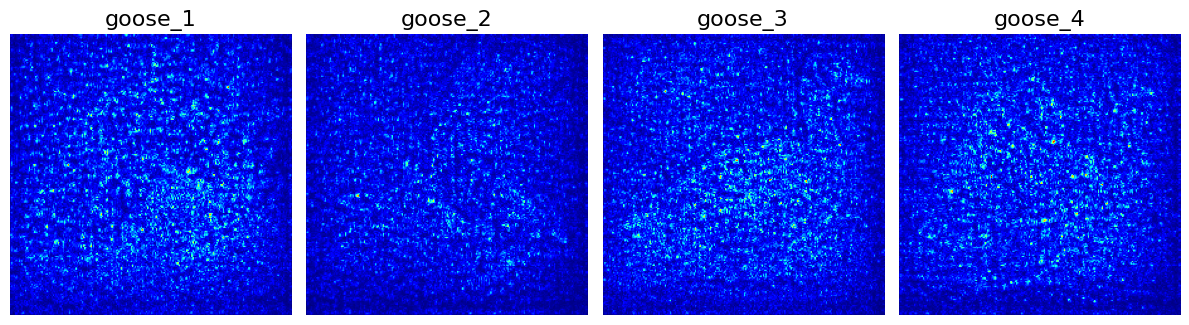

In [47]:
rect =  RectifiedBackpropagation()
from tf_keras_vis.saliency import Saliency

saliency = Saliency(model,
                    model_modifier=[replace2linear, rect],
                    clone=True)

saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GUIDED

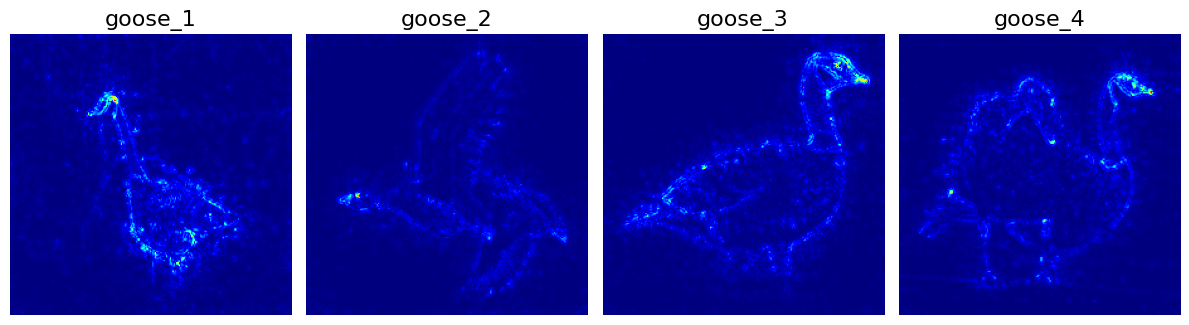

In [17]:
from tf_keras_vis.saliency import Saliency


saliency = Saliency(model,
                    model_modifier=[replace2linear, guided],
                    clone=True)

saliency_map = saliency(score, X)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(saliency_map[i], cmap='jet')
    ax[i].axis('off')
plt.tight_layout()
plt.show()

* Оценить полученный результат на прошлом этапе и отображение
признаков с помощью управляемой значимости
(backprop_modifier='guided') и устранения деконверсии
(backprop_modifier='relu')

Преобразование градиентов guided - помогает убрать "шум" из отображения активаций, в то время как rectified его только увеличивает, путем увеличения ненулевых значений. Для с метода Silience модификатор guided имеет большое значение и позволяет четче видеть области активаций.

### **Использование GradCAM для определения ключевых областей изображения**

* Получить краткое описание модели

* Выполнить построение карт значимости классов для выбранных
изображений методами vanila, guided, rectified
* Сделать выводы о наиболее точном и полном методе описания
активаций слоев нейронной сети.

In [22]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## VANILA GRADCAM

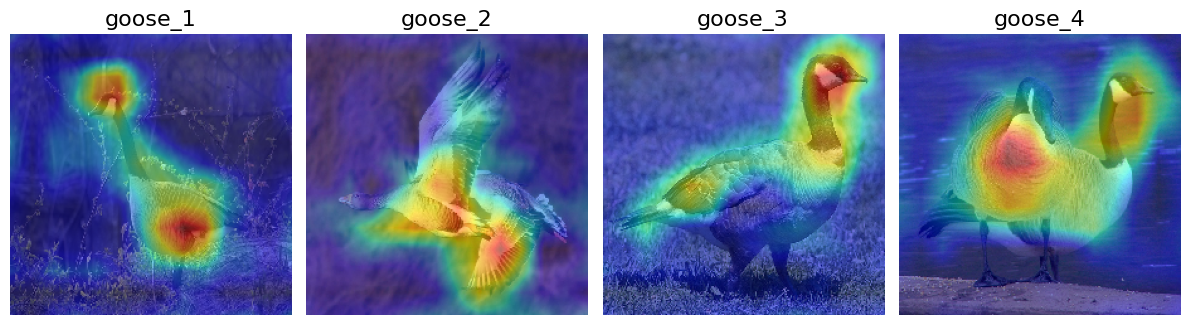

In [25]:
from matplotlib import cm
from tf_keras_vis.gradcam import Gradcam

gradcam = Gradcam(model,
                  model_modifier=replace2linear,
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## GUIDED GRADCAM

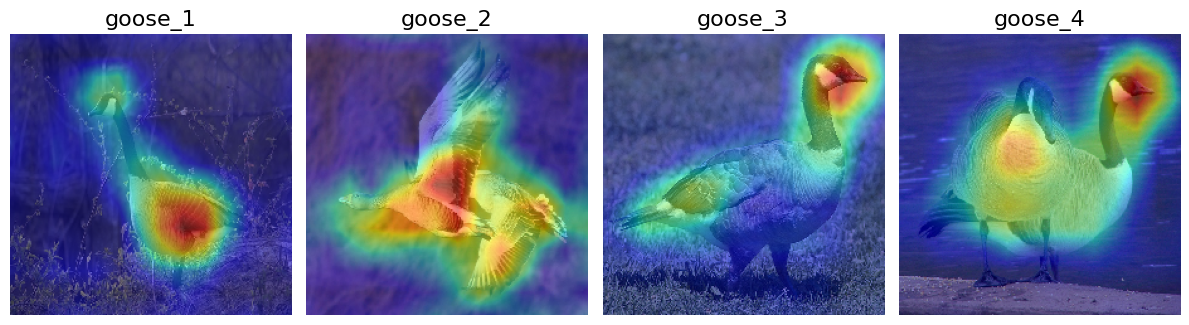

In [26]:
gradcam = Gradcam(model,
                  model_modifier=[replace2linear, guided],
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

## RECTIFIED GRADCAM

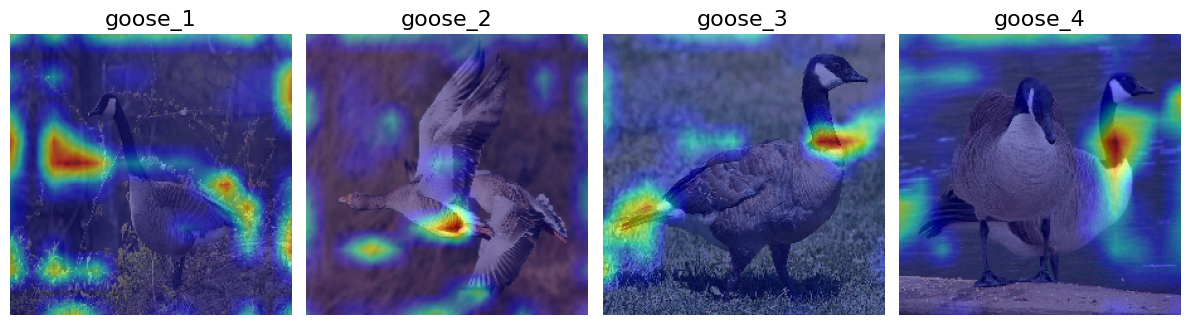

In [48]:
gradcam = Gradcam(model,
                  model_modifier=[replace2linear, rect],
                  clone=True)

cam = gradcam(score,
              X,
              penultimate_layer=-1)

f, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    heatmap = np.uint8(cm.jet(cam[i])[..., :3] * 255)
    ax[i].set_title(title, fontsize=16)
    ax[i].imshow(images[i])
    ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
    ax[i].axis('off')
plt.tight_layout()
plt.show()

# ВАЖНО!! Сам разработчик заявил, что метод guided не работает для GRADCAM в данной версии keras-vis:
# **Warnings: Please note that there is a discussion that Guided Backpropagation is not working well as         model explanations.**

Можно сказать, что в данном случае **guided backprop** не внес весомых улучшений относительно шума. Однако, если приглядеться, можно заметить, что шума стало все-таки немного меньше.

Метод RELU (Rectified) снова не дал хороших результатов в визуализации активаций

# **ВЫВОД: Наиболее точный и полный метод описания активаций слоев нейронной сети - guided backpropogation.  Метод направлен на устранение неинформативных областей на визуализациях градиентов, полученных обычным backpropogation, используемым для визуализации.**